In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:

# Read in data, select relevant cols
ge = pd.read_csv('../data/president_polls.csv')
ge = ge[['poll_id', 'fte_grade', 'sample_size', 'start_date', 'answer', 'pct']]

# Only use good polls (according to 538)
ge = ge[ge['fte_grade'].isin(['A+', 'A', 'A-', 'A/B', 'B+', 'B'])]
ge.drop('fte_grade', axis=1, inplace=True)

# Set index to date
ge['start_date'] = pd.to_datetime(ge['start_date'])
ge.set_index('start_date', inplace=True)
ge.sort_index(inplace=True)

C:\Users\david\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (6,22,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Check to see the latest date with primary candidates still.
ge[ge['answer'] == 'Sanders']

,poll_id,sample_size,answer,pct
start_date,,,,
2018-11-27,57026,648.0,Sanders,47.0
2019-01-04,57275,750.0,Sanders,48.0
2019-01-19,57365,760.0,Sanders,51.0
2019-01-30,57445,831.0,Sanders,49.5
2019-02-14,57532,1000.0,Sanders,51.3
...,...,...,...,...
2020-03-27,65043,777.0,Sanders,43.0
2020-03-29,65680,980.0,Sanders,43.0
2020-03-29,65045,1194.0,Sanders,45.0


In [5]:
# Drop all primary dates, only need Biden and Trump
ge = ge[ge.index > '2020-04-06']
ge = ge[ge.answer.isin(['Biden', 'Trump'])]

In [6]:
# Use a pivot table to get Biden and Trump pct in the same row
runoff = ge.pivot_table('pct', ['start_date', 'poll_id', 'sample_size'], 'answer').reset_index().set_index('start_date')
runoff

answer,poll_id,sample_size,Biden,Trump
start_date,,,,
2020-04-10,65918,1200.0,44.0,49.0
2020-04-12,65756,1166.0,48.0,43.0
2020-04-13,65781,900.0,49.0,42.0
2020-04-14,65761,1318.0,48.0,47.0
2020-04-16,65841,1385.0,46.0,42.0
...,...,...,...,...
2020-10-30,72619,1501.0,49.0,41.0
2020-10-31,72714,1363.0,53.0,43.0
2020-10-31,72714,1500.0,49.0,40.0


In [7]:

# Weight percentages by sample sizes
runoff['total_biden'] = runoff['Biden'] * runoff['sample_size']
runoff['total_trump'] = runoff['Trump'] * runoff['sample_size']
overall_runoff = runoff.groupby('start_date')[['sample_size', 'total_biden', 'total_trump']].sum().sort_index()
overall_runoff['w_biden'] = overall_runoff['total_biden'] / overall_runoff['sample_size']
overall_runoff['w_trump'] = overall_runoff['total_trump'] / overall_runoff['sample_size']

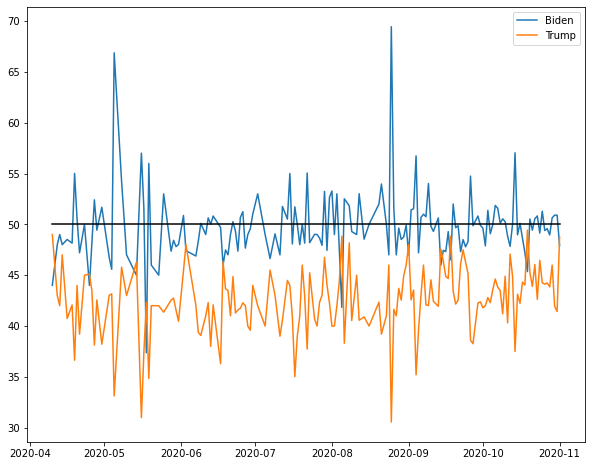

In [8]:

plt.figure(figsize=(10,8))
plt.plot(overall_runoff.index, overall_runoff['w_biden'], label='Biden')
plt.plot(overall_runoff.index, overall_runoff['w_trump'], label='Trump')
plt.plot(overall_runoff.index, [50 for i in overall_runoff.index], color='black')
plt.legend()
plt.show()

In [9]:
overall_runoff.to_csv('../data/general_election.csv')

In [10]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma
window = 7
running_avg_biden = movingaverage(overall_runoff['w_biden'], window)
running_avg_trump = movingaverage(overall_runoff['w_trump'], window)

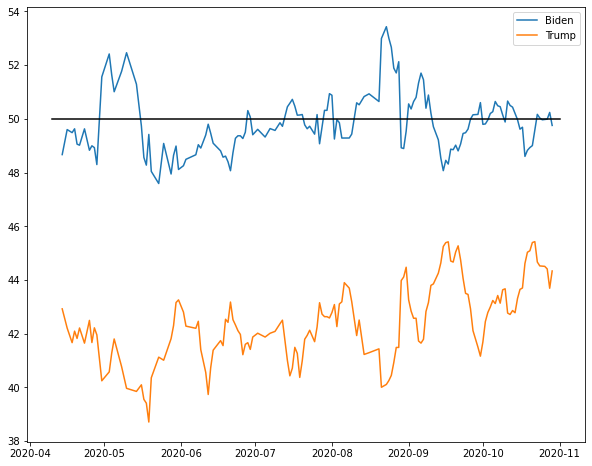

In [11]:
plt.figure(figsize=(10,8))
plt.plot(overall_runoff.index[window//2:-((window-1)//2)], running_avg_biden, label='Biden') #account for running average removing ends
plt.plot(overall_runoff.index[window//2:-((window-1)//2)], running_avg_trump, label='Trump')
plt.plot(overall_runoff.index, [50 for i in overall_runoff.index], color='black')
plt.legend()
plt.show()